In [44]:
import numpy as np
np.bool = np.bool_
import pyemma.msm as msm
import pyemma.plots as mplt
import matplotlib as mt
import matplotlib.pyplot as plt
import MDAnalysis as mda
import sys
sys.path.append('../0_python_modules/')
import msm_analysis as ana

### urf_h2
<font size=4>
    <br>
    for pc=3 <br>
    i = 3 <br>
    cl = 30, 50, 500, 700, 1000 <br>
    ml = 40 <br>
    <br>
    <br>
    for pc = 4 <br>
    i=0 <br>
    20, 5   # cl, ml <br> 
    30, 10 <br>
    30, 15 <br>
    1500, 10 <br>
    <br>
    i=1 <br>
    20, 45 <br>
    <br>
    i=4 <br>
    250, 5 <br>
    350, 10 <br>
    <br>

In [2]:
colors = np.array(['salmon', 'dodgerblue', 'teal', 'limegreen', 'sienna', 'violet'])
cmaps = [mt.colors.LinearSegmentedColormap.from_list('', colors[:i], N=i) for i in range(3, 7)]

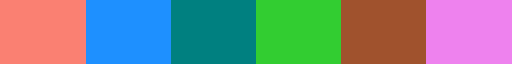

In [3]:
cmaps[3]

In [42]:
trajs = np.array([
    f'LONG_TRAJ/{i}.xtc' for i in ['1f','2_2','2f_1','3_1','3_2','4f','5f']
] + [
    f'SHORT_TRAJ_subunit1/{i}.xtc' for i in range(1,63)
] + [
    f'SHORT_TRAJ_subunit2/{i}.xtc' for i in range(1,41)
] + [
    f'SHORT_TRAJ_intermediate/{i}.xtc' for i in range(1,21)
])
path = '../1_datasets/mopR_bindings/'
pdb = 'p2e.pdb'

In [5]:
def get_frames(model, mdis, dtrj, stds, 
               microstate='large', trj='most'):
    xtcs = []
    frames = []
    for a,macro in enumerate(mdis):
        if microstate=='large':
            micro = macro[ stds[macro].argmax() ]
        else:
            micro = macro[ stds[macro].argmin() ]
            
        nframes = [np.where(dd==micro)[0].shape[0] for dd in dtrj]
        if trj=='most':
            dd = np.argmax(nframes)
        else:
            dd = np.argmin(nframes)
            
        frames.append( np.where(dtrj[dd] == micro)[0] )
        xtcs.append(dd)
        
    return xtcs, frames

In [25]:
def write_frames(path, pdb, trajs, idata,
                tid, fid, nconfs=10, otype='random', sel='all',
                ofmt='pdb', opath='./', oname='frame'):
    
    uni = mda.Universe(f'{path}{pdb}', f'{path}{trajs[tid]}')
    
    dd = idata[tid][fid]
    
    if otype=='random':
        np.random.seed(0)
        oframes = np.random.choice(fid, nconfs)
    elif otype == 'min':
        oframes = fid[dd.argsort()[:nconfs]]
    elif otype == 'max':
        oframes = fid[dd.argsort()[::-1][:nconfs]]
    elif otype == 'variable':
        oframes = fid[dd.argsort()[::int(len(fid)/nconfs)][:nconfs]]
    else:
        raise ValueError(f'{otype} not in [random, variable, min, max]')
        
    for a,i in enumerate(oframes):
        uni.trajectory[i]
        uni.select_atoms(f'{sel}').write(f'{opath}{oname}{a}.{ofmt}')

In [26]:
idata = np.load('../1_datasets/mopR_bindings/distance_alldata.npy', allow_pickle=True)

# h=2, i=4, cl=250, ml=5, pc=4

In [27]:
h=2
i=4
cl=250
ml=5
pc=4

In [28]:
tic2 = np.load(f'ticas/h{h}_tic2_{i}.npz')
tic2 = np.concatenate(([tic2[k] for k in list(tic2)]))

dtrj = np.load(f'urf/saved_h{2}_msm/dtraj_{i}_{cl}.npz')
dtrj = [dtrj[k] for k in list(dtrj)]

model = msm.estimate_markov_model(dtrj, lag=ml)
model.pcca(pc)
mdis=model.metastable_sets
mdis

[array([  5,   9,  24,  25,  47,  49,  59,  64,  67,  68,  95,  97,  98,
        106, 129, 152, 155, 159, 179, 203, 206, 215, 235]),
 array([ 13,  15,  23,  35,  40,  61,  66,  89,  91,  93, 109, 117, 146,
        147, 156, 164, 168, 186, 205, 209, 219, 220, 221, 228, 240, 242]),
 array([  1,   3,  10,  20,  26,  29,  30,  34,  39,  52,  55,  57,  58,
         69,  73,  83,  84,  86,  99, 108, 111, 118, 119, 122, 127, 130,
        135, 139, 148, 150, 157, 169, 170, 172, 177, 180, 185, 189, 194,
        199, 208, 211, 212, 218, 223, 224, 227, 231, 238, 243, 245]),
 array([  0,   2,   4,   6,   7,   8,  11,  12,  14,  16,  17,  18,  19,
         21,  22,  27,  28,  31,  32,  33,  36,  37,  38,  41,  42,  43,
         44,  45,  46,  48,  50,  51,  53,  54,  56,  60,  62,  63,  65,
         70,  71,  72,  74,  75,  76,  77,  78,  79,  80,  81,  82,  85,
         87,  88,  90,  92,  94,  96, 100, 101, 102, 103, 104, 105, 107,
        110, 112, 113, 114, 115, 116, 120, 121, 123, 124, 125, 12

In [29]:
pr = ana.analyze_msm_clusters(dtrj)
pr.take_data(np.load('../1_datasets/mopR_bindings/distance_alldata.npy', allow_pickle=True))
means, stds, probs = pr.get_mean()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:04<00:00, 27.21it/s]


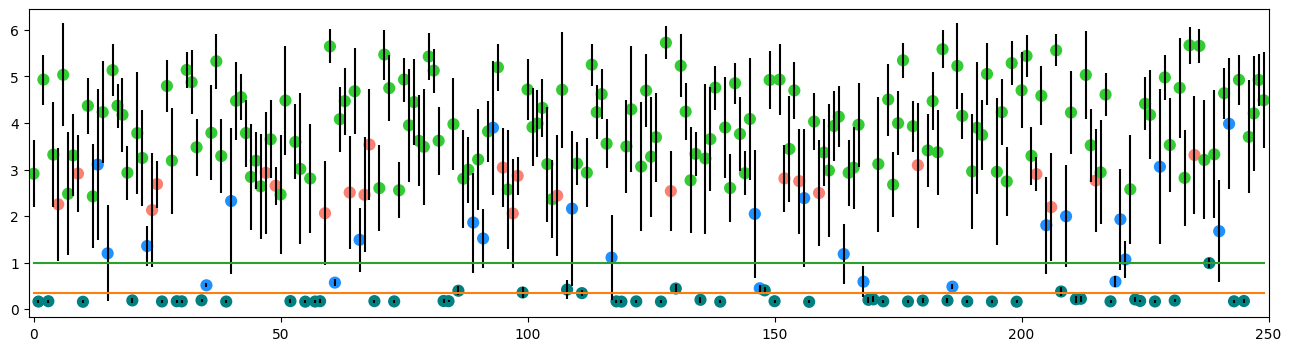

In [40]:
mcolors = np.zeros((cl))
for a,k in enumerate(model.metastable_sets):
    mcolors[k] = a
    
fig,ax=plt.subplots(1, figsize=(16,4))
ax.errorbar(range(cl), means, fmt='.', yerr=stds, ms=0, ecolor='black')
ax.scatter(range(cl), means, c=colors[mcolors.astype(int)], s=60)
ax.plot([0,cl-1],[0.35,0.35])
ax.plot([0,cl-1],[1,1])
ax.set_xlim(-1,cl)
plt.show()

In [30]:
state_labels = ['I2','I','B','U']

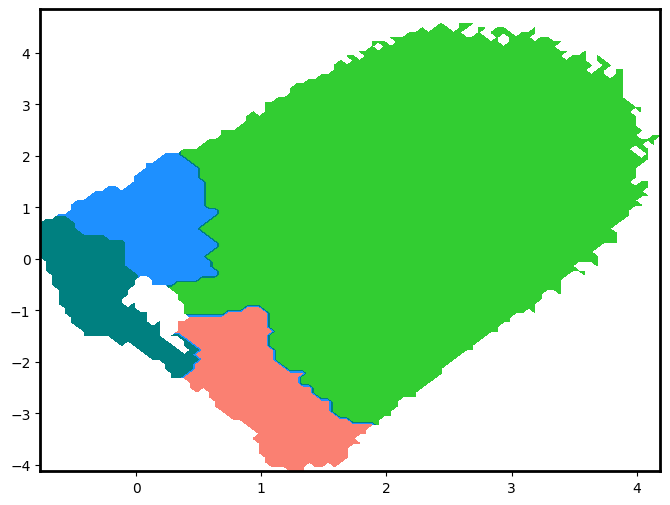

In [31]:
fig,ax=plt.subplots(1,figsize=(8,6))
mplt.plot_state_map(tic2[:,0], tic2[:,1],
                   model.metastable_assignments[np.concatenate((model.dtrajs_active))],
                   cbar=False, cmap=cmaps[pc-3], ax=ax)
ax.spines[:].set_linewidth(2)
plt.savefig(f'plots/statemap_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [32]:
for a, k in enumerate(mdis): print(a,model.pi[k].sum())

0 0.042845145736853225
1 0.06597302714402531
2 0.7331047556378858
3 0.15807707148123507


In [33]:
fr = ml * 10 * 10**(-6)
for k in range(pc-1):
    for j in range(k+1,pc):
        print(k,j,model.mfpt(mdis[k], mdis[j])*fr, model.mfpt(mdis[j], mdis[k])*fr)

0 1 0.0857222434323466 0.8367156321174499
0 2 0.26110586545496334 1.2064915396286005
0 3 0.01707584298107935 0.26703950379865954
1 2 0.10550196762831196 0.11698393009321338
1 3 0.44050837195229575 0.0696846227007968
2 3 0.8266006821413565 0.25619660785790277


In [34]:
mdtrj = ana.get_mdtrj(dtrj, mdis, output_type='trj')
mmodel = msm.estimate_markov_model(mdtrj, lag=ml)

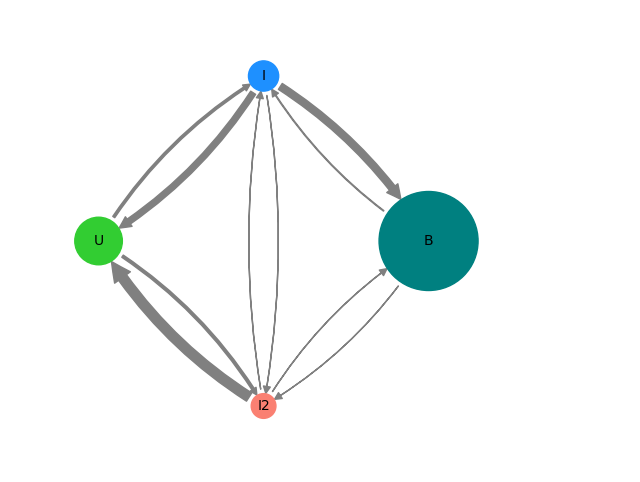

In [46]:
fig,ax=plt.subplots(1, figsize=(8,6))
mplt.plot_markov_model(mmodel, 
                       pos=np.array([[1,-1],[1,1],[2,0],[0,0]]), 
                       state_colors=colors[:pc], state_labels=state_labels,
                       arrow_labels=None, arrow_scale=1.4, ax=ax
                      )
plt.savefig(f'plots/markov_model_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [47]:
flux = msm.tpt(model, mdis[3], mdis[2])
cg, cgflux = flux.coarse_grain(mdis)
print(cgflux.committor)
paths, path_fluxes = cgflux.pathways(fraction=0.99)
for a,i in enumerate(paths):
    print(i, path_fluxes[a]/np.sum(path_fluxes))

[0.         0.02128893 0.54677273 1.        ]
[0 2 3] 0.8777030888759572
[0 1 3] 0.12229691112404273


In [40]:
fid=get_frames(model, mdis, dtrj, stds)
fid

([1, 1, 89, 2],
 [array([ 44228,  44232,  44236, ..., 319822, 319823, 319842]),
  array([ 16241,  16362,  16383, ..., 275938, 275952, 313708]),
  array([  97,   98,   99, ..., 4845, 4847, 4850]),
  array([10159, 12388, 12404, ..., 72829, 72830, 72831])])

In [48]:
for i in zip(fid[0], fid[1], ['variable','max','min','max'], ['i2', 'int', 'bound', 'unbound']):
    write_frames(path=path, pdb=pdb, trajs=trajs, idata=idata,
                tid=i[0], fid=i[1], nconfs=20, otype=i[2], sel='all',
                opath='saved_MSM4/', oname=i[3])

# h=2, i=1, cl=20, ml=45, pc=4

In [49]:
h=2
i=1
cl=20
ml=45
pc=4

In [50]:
tic2 = np.load(f'ticas/h{h}_tic2_{i}.npz')
tic2 = np.concatenate(([tic2[k] for k in list(tic2)]))

dtrj = np.load(f'urf/saved_h{2}_msm/dtraj_{i}_{cl}.npz')
dtrj = [dtrj[k] for k in list(dtrj)]

model = msm.estimate_markov_model(dtrj, lag=ml)
model.pcca(pc)
mdis=model.metastable_sets
mdis

[array([16]),
 array([ 5, 13]),
 array([ 0,  2,  3,  4,  6,  7,  8,  9, 12, 14, 15, 17, 18, 19]),
 array([ 1, 10, 11])]

In [51]:
pr = ana.analyze_msm_clusters(dtrj)
pr.take_data(np.load('../1_datasets/mopR_bindings/distance_alldata.npy', allow_pickle=True))
means, stds, probs = pr.get_mean()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:04<00:00, 26.29it/s]


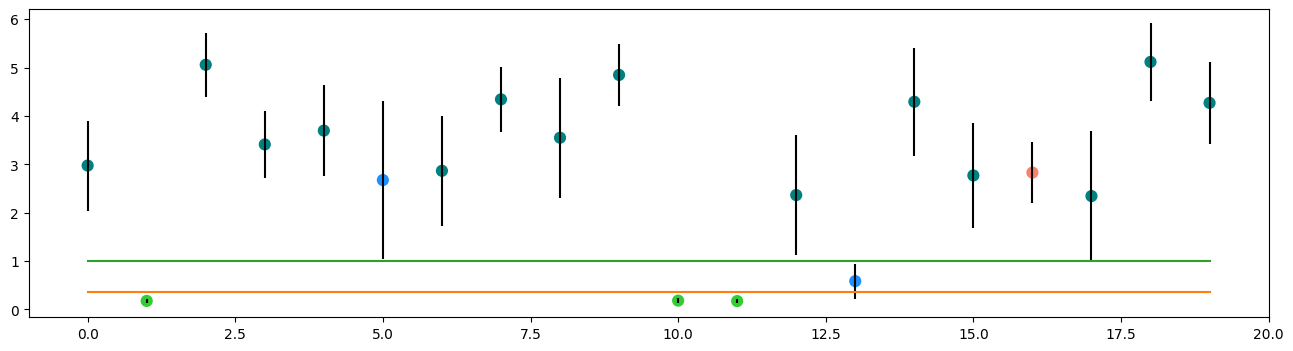

In [52]:
mcolors = np.zeros((cl))
for a,k in enumerate(model.metastable_sets):
    mcolors[k] = a
    
fig,ax=plt.subplots(1, figsize=(16,4))
ax.errorbar(range(cl), means, fmt='.', yerr=stds, ms=0, ecolor='black')
ax.scatter(range(cl), means, c=colors[mcolors.astype(int)], s=60)
ax.plot([0,cl-1],[0.35,0.35])
ax.plot([0,cl-1],[1,1])
ax.set_xlim(-1,cl)
plt.show()

In [54]:
state_labels=['I2','I','U','B']

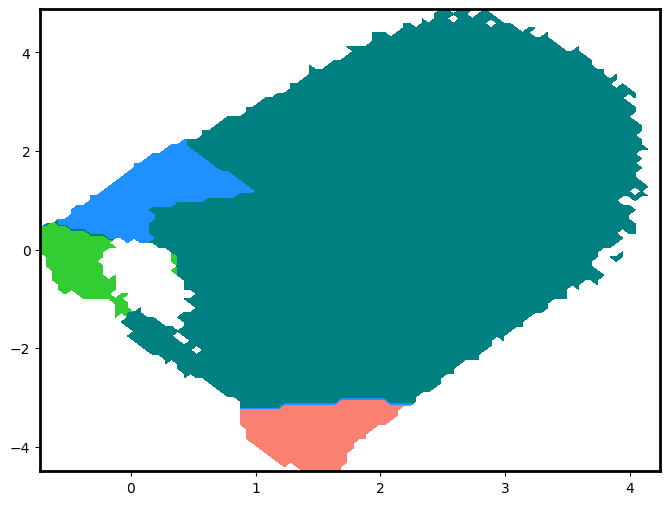

In [55]:
fig,ax=plt.subplots(1,figsize=(8,6))
mplt.plot_state_map(tic2[:,0], tic2[:,1],
                   model.metastable_assignments[np.concatenate((model.dtrajs_active))],
                   cbar=False, cmap=cmaps[pc-3], ax=ax)
ax.spines[:].set_linewidth(2)
plt.savefig(f'plots/statemap_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [56]:
for a, k in enumerate(mdis): print(a,model.pi[k].sum())

0 0.012529644922965695
1 0.06525825432418329
2 0.1769048836389011
3 0.7453072171139498


In [57]:
fr = ml * 10 * 10**(-6)
for k in range(pc-1):
    for j in range(k+1,pc):
        print(k,j,model.mfpt(mdis[k], mdis[j])*fr, model.mfpt(mdis[j], mdis[k])*fr)

0 1 1.673778137704944 23.29817352412288
0 2 0.11232347016502145 11.714742984306335
0 3 5.02954350999833 29.85805202023885
1 2 8.722898104633343 1.3491923769854282
1 3 2.010434809563373 3.318746226475579
2 3 4.708385702900486 15.264738941457928


In [58]:
mdtrj = ana.get_mdtrj(dtrj, mdis, output_type='trj')
mmodel = msm.estimate_markov_model(mdtrj, lag=ml)

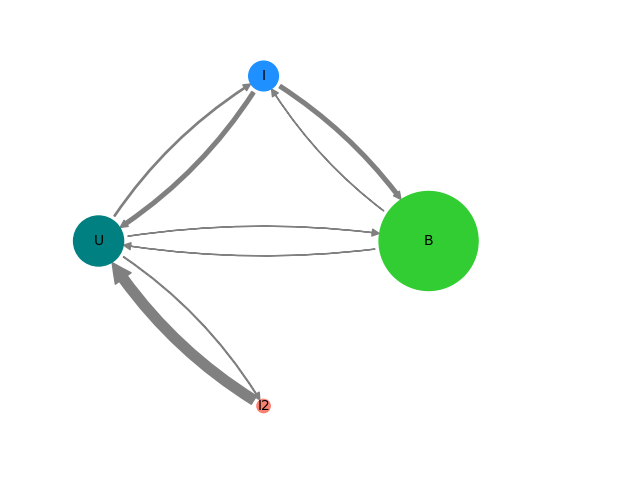

In [60]:
fig,ax=plt.subplots(1, figsize=(8,6))
mplt.plot_markov_model(mmodel, 
                       pos=np.array([[1,-1],[1,1],[0,0],[2,0]]), 
                       state_colors=colors[:pc], state_labels=state_labels,
                       arrow_labels=None, arrow_scale=1.4, ax=ax
                      )
plt.savefig(f'plots/markov_model_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [61]:
flux = msm.tpt(model, mdis[3], mdis[2])
cg, cgflux = flux.coarse_grain(mdis)
print(cgflux.committor)
paths, path_fluxes = cgflux.pathways(fraction=0.99)
for a,i in enumerate(paths):
    print(i, path_fluxes[a]/np.sum(path_fluxes))

[0.         0.99998621 0.43697483 1.        ]
[0 2 3] 0.9837275030667648
[0 3] 0.016272496933235226


In [62]:
get_frames(model, mdis, dtrj, stds)

([0, 1, 1, 0],
 [array([   66,   939,  1914, ..., 54218, 54219, 54220]),
  array([  2805,   2810,   2811, ..., 317734, 317752, 317754]),
  array([   928,    938,    939, ..., 318936, 318937, 318939]),
  array([ 59356,  59530,  59536, ..., 394216, 394217, 394218])])

# h=2, i=0, cl=20, ml=5, pc=4

In [63]:
h=2
i=0
cl=20
ml=5
pc=4

In [64]:
tic2 = np.load(f'ticas/h{h}_tic2_{i}.npz')
tic2 = np.concatenate(([tic2[k] for k in list(tic2)]))

dtrj = np.load(f'urf/saved_h{2}_msm/dtraj_{i}_{cl}.npz')
dtrj = [dtrj[k] for k in list(dtrj)]

model = msm.estimate_markov_model(dtrj, lag=ml)
model.pcca(pc)
mdis=model.metastable_sets
mdis

[array([ 3, 14, 15]),
 array([ 0,  2,  4,  6,  7,  8,  9, 10, 11, 12, 17, 19]),
 array([13, 16]),
 array([ 1,  5, 18])]

In [65]:
pr = ana.analyze_msm_clusters(dtrj)
pr.take_data(np.load('../1_datasets/mopR_bindings/distance_alldata.npy', allow_pickle=True))
means, stds, probs = pr.get_mean()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:05<00:00, 25.78it/s]


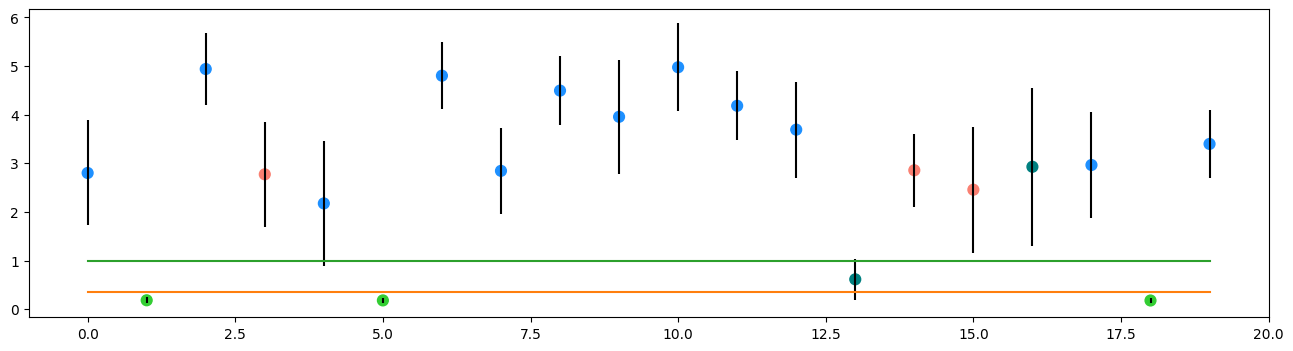

In [66]:
mcolors = np.zeros((cl))
for a,k in enumerate(model.metastable_sets):
    mcolors[k] = a
    
fig,ax=plt.subplots(1, figsize=(16,4))
ax.errorbar(range(cl), means, fmt='.', yerr=stds, ms=0, ecolor='black')
ax.scatter(range(cl), means, c=colors[mcolors.astype(int)], s=60)
ax.plot([0,cl-1],[0.35,0.35])
ax.plot([0,cl-1],[1,1])
ax.set_xlim(-1,cl)
plt.show()

In [67]:
state_labels=['I2','U','I','B']

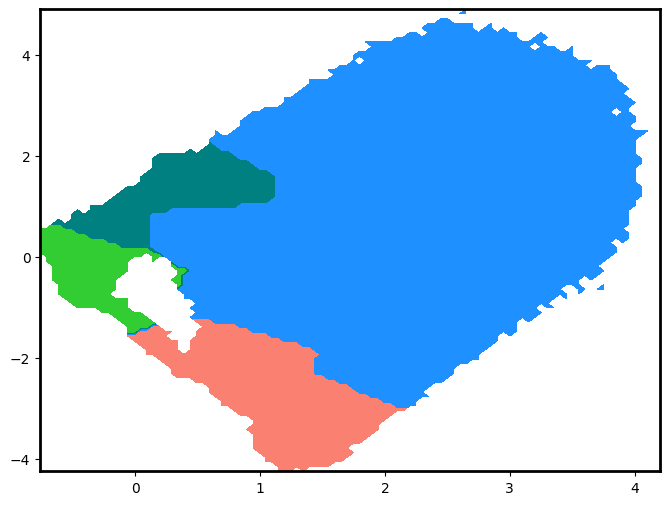

In [68]:
fig,ax=plt.subplots(1,figsize=(8,6))
mplt.plot_state_map(tic2[:,0], tic2[:,1],
                   model.metastable_assignments[np.concatenate((model.dtrajs_active))],
                   cbar=False, cmap=cmaps[pc-3], ax=ax)
ax.spines[:].set_linewidth(2)
plt.savefig(f'plots/statemap_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [69]:
for a, k in enumerate(mdis): print(a,model.pi[k].sum())

0 0.050898222269143756
1 0.16442245506693323
2 0.06410781155816214
3 0.7205715111057609


In [70]:
fr = ml * 10 * 10**(-6)
for k in range(pc-1):
    for j in range(k+1,pc):
        print(k,j,model.mfpt(mdis[k], mdis[j])*fr, model.mfpt(mdis[j], mdis[k])*fr)

0 1 0.010513117398700526 0.18461217034148825
0 2 0.04489901259670911 0.37202187371373086
0 3 0.10579053965906077 0.4874094777413069
1 2 0.028703386053204778 0.12019657224318413
1 3 0.09335287078466847 0.23959899932767378
2 3 0.04229303303145028 0.06591969784753948


In [71]:
mdtrj = ana.get_mdtrj(dtrj, mdis, output_type='trj')
mmodel = msm.estimate_markov_model(mdtrj, lag=ml)

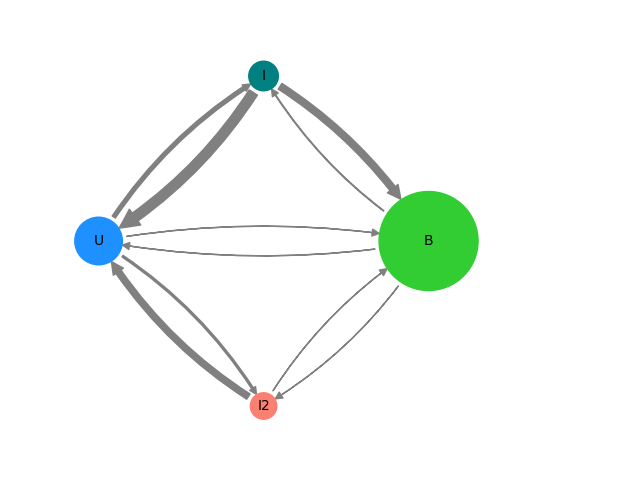

In [72]:
fig,ax=plt.subplots(1, figsize=(8,6))
mplt.plot_markov_model(mmodel, 
                       pos=np.array([[1,-1],[0,0],[1,1],[2,0]]), 
                       state_colors=colors[:pc], state_labels=state_labels,
                       arrow_labels=None, arrow_scale=1.4, ax=ax
                      )
plt.savefig(f'plots/markov_model_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [74]:
flux = msm.tpt(model, mdis[1], mdis[3])
cg, cgflux = flux.coarse_grain(mdis)
print(cgflux.committor)
paths, path_fluxes = cgflux.pathways(fraction=0.99)
for a,i in enumerate(paths):
    print(i, path_fluxes[a]/np.sum(path_fluxes))

[0.         0.0161166  0.49346781 1.        ]
[0 2 3] 0.9457046080701461
[0 1 3] 0.041905697460173114
[0 3] 0.012389694469680744


In [75]:
get_frames(model, mdis, dtrj, stds)

([1, 1, 1, 0],
 [array([  1228,   1229,   1231, ..., 322054, 322055, 322057]),
  array([  2797,   2798,   2799, ..., 318935, 318936, 318937]),
  array([   926,    930,    931, ..., 317716, 317733, 317752]),
  array([ 59355,  59544,  59545, ..., 394157, 394158, 394164])])

# h=2, i=0, cl=30, ml=10, pc=4

In [6]:
h=2
i=0
cl=30
ml=10
pc=4

In [7]:
tic2 = np.load(f'ticas/h{h}_tic2_{i}.npz')
tic2 = np.concatenate(([tic2[k] for k in list(tic2)]))

dtrj = np.load(f'urf/saved_h{2}_msm/dtraj_{i}_{cl}.npz')
dtrj = [dtrj[k] for k in list(dtrj)]

model = msm.estimate_markov_model(dtrj, lag=ml)
model.pcca(pc)
mdis=model.metastable_sets
mdis

[array([ 3,  6, 12, 13, 20]),
 array([11, 23, 27]),
 array([ 0,  2,  5,  7,  8,  9, 10, 14, 16, 17, 19, 21, 22, 24, 25, 26, 28,
        29]),
 array([ 1,  4, 15, 18])]

In [8]:
pr = ana.analyze_msm_clusters(dtrj)
pr.take_data(np.load('../1_datasets/mopR_bindings/distance_alldata.npy', allow_pickle=True))
means, stds, probs = pr.get_mean()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:04<00:00, 27.22it/s]


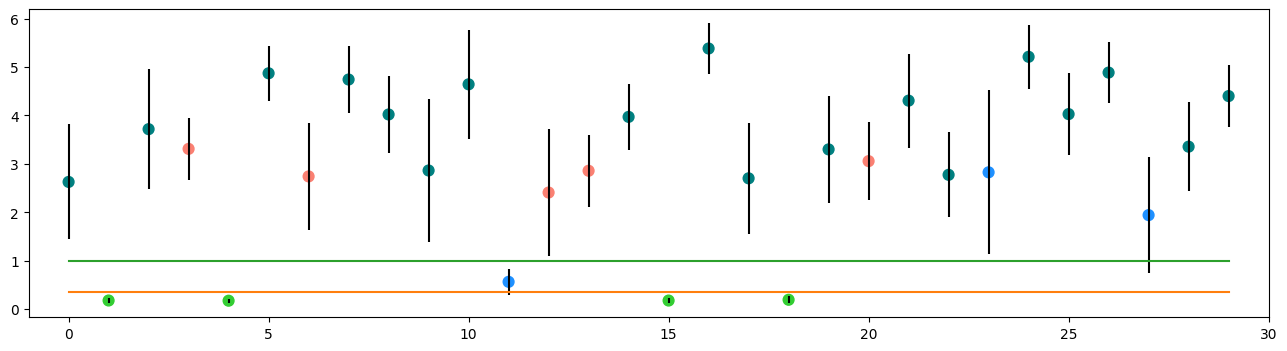

In [9]:
mcolors = np.zeros((cl))
for a,k in enumerate(model.metastable_sets):
    mcolors[k] = a
    
fig,ax=plt.subplots(1, figsize=(16,4))
ax.errorbar(range(cl), means, fmt='.', yerr=stds, ms=0, ecolor='black')
ax.scatter(range(cl), means, c=colors[mcolors.astype(int)], s=60)
ax.plot([0,cl-1],[0.35,0.35])
ax.plot([0,cl-1],[1,1])
ax.set_xlim(-1,cl)
plt.show()

In [10]:
state_labels=['I2','I','U','B']

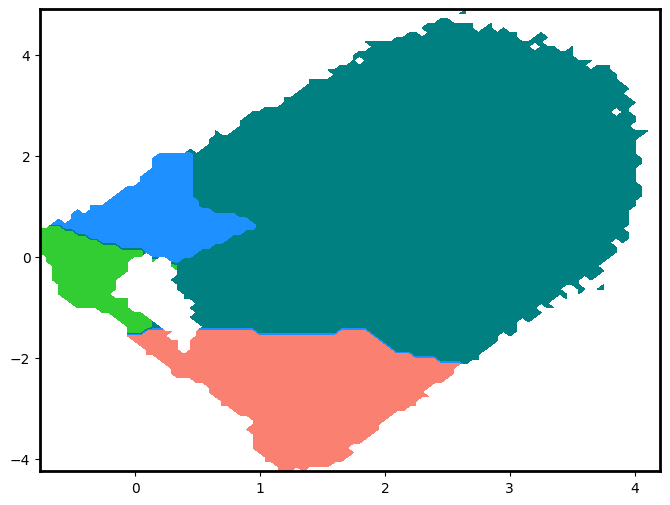

In [11]:
fig,ax=plt.subplots(1,figsize=(8,6))
mplt.plot_state_map(tic2[:,0], tic2[:,1],
                   model.metastable_assignments[np.concatenate((model.dtrajs_active))],
                   cbar=False, cmap=cmaps[pc-3], ax=ax)
ax.spines[:].set_linewidth(2)
plt.savefig(f'plots/statemap_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [81]:
for a, k in enumerate(mdis): print(a,model.pi[k].sum())

0 0.0634816684403822
1 0.07074971543611334
2 0.14023132136820454
3 0.7255372947552999


In [82]:
fr = ml * 10 * 10**(-6)
for k in range(pc-1):
    for j in range(k+1,pc):
        print(k,j,model.mfpt(mdis[k], mdis[j])*fr, model.mfpt(mdis[j], mdis[k])*fr)

0 1 0.16666377263526022 1.1260254015794624
0 2 0.04681914758754215 0.33749566197494413
0 3 0.4118394316401437 1.6062833108965473
1 2 0.6053076197743279 0.12099523706562587
1 3 0.16565911477304834 0.23787110639744077
2 3 0.37698956177450466 1.098942451631915


In [83]:
mdtrj = ana.get_mdtrj(dtrj, mdis, output_type='trj')
mmodel = msm.estimate_markov_model(mdtrj, lag=ml)

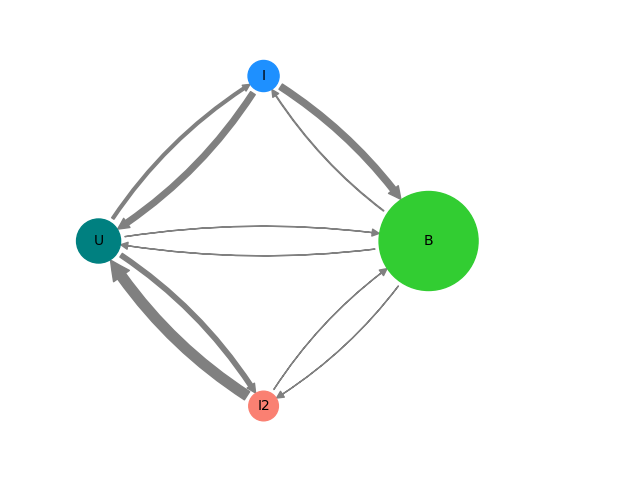

In [85]:
fig,ax=plt.subplots(1, figsize=(8,6))
mplt.plot_markov_model(mmodel, 
                       pos=np.array([[1,-1],[1,1],[0,0],[2,0]]), 
                       state_colors=colors[:pc], state_labels=state_labels,
                       arrow_labels=None, arrow_scale=1.4, ax=ax
                      )
plt.savefig(f'plots/markov_model_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [86]:
flux = msm.tpt(model, mdis[2], mdis[3])
cg, cgflux = flux.coarse_grain(mdis)
print(cgflux.committor)
paths, path_fluxes = cgflux.pathways(fraction=0.99)
for a,i in enumerate(paths):
    print(i, path_fluxes[a]/np.sum(path_fluxes))

[0.         0.01694935 0.54167371 1.        ]
[0 2 3] 0.9528234785122093
[0 1 3] 0.04717652148779067


In [87]:
get_frames(model, mdis, dtrj, stds)

([1, 1, 1, 4],
 [array([  1334,  11453,  11454, ..., 322054, 322055, 322057]),
  array([  3690,   3694,   3697, ..., 317733, 317752, 317754]),
  array([   926,    930,    931, ..., 317701, 317702, 317705]),
  array([ 63145,  63146,  63147, ..., 169596, 169600, 169601])])

# h=2, i=0, cl=30, ml=15, pc=4

In [12]:
h=2
i=0
cl=30
ml=15
pc=4

In [13]:
tic2 = np.load(f'ticas/h{h}_tic2_{i}.npz')
tic2 = np.concatenate(([tic2[k] for k in list(tic2)]))

dtrj = np.load(f'urf/saved_h{2}_msm/dtraj_{i}_{cl}.npz')
dtrj = [dtrj[k] for k in list(dtrj)]

model = msm.estimate_markov_model(dtrj, lag=ml)
model.pcca(pc)
mdis=model.metastable_sets
mdis

[array([ 6, 12, 13]),
 array([11, 23, 27]),
 array([ 1,  4, 15, 18]),
 array([ 0,  2,  3,  5,  7,  8,  9, 10, 14, 16, 17, 19, 20, 21, 22, 24, 25,
        26, 28, 29])]

In [14]:
pr = ana.analyze_msm_clusters(dtrj)
pr.take_data(np.load('../1_datasets/mopR_bindings/distance_alldata.npy', allow_pickle=True))
means, stds, probs = pr.get_mean()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:04<00:00, 26.97it/s]


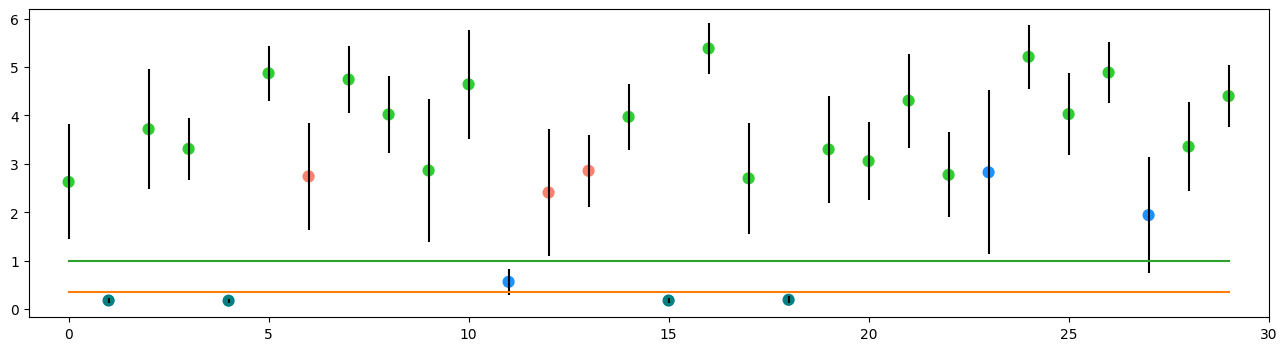

In [15]:
mcolors = np.zeros((cl))
for a,k in enumerate(model.metastable_sets):
    mcolors[k] = a
    
fig,ax=plt.subplots(1, figsize=(16,4))
ax.errorbar(range(cl), means, fmt='.', yerr=stds, ms=0, ecolor='black')
ax.scatter(range(cl), means, c=colors[mcolors.astype(int)], s=60)
ax.plot([0,cl-1],[0.35,0.35])
ax.plot([0,cl-1],[1,1])
ax.set_xlim(-1,cl)
plt.show()

In [16]:
state_labels=['I2','I','B','U']

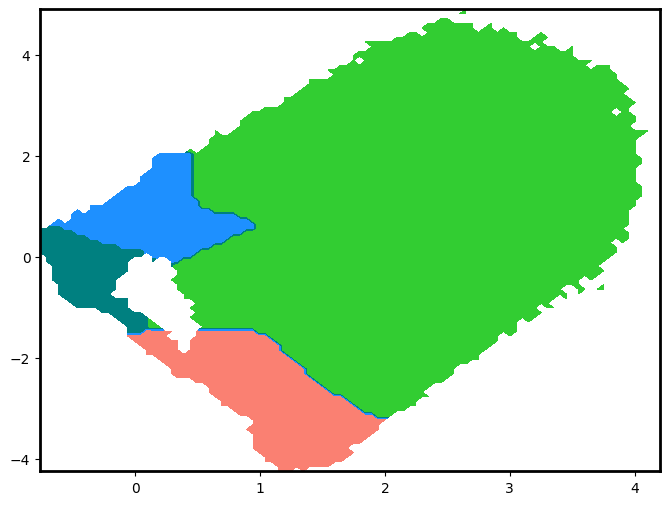

In [17]:
fig,ax=plt.subplots(1,figsize=(8,6))
mplt.plot_state_map(tic2[:,0], tic2[:,1],
                   model.metastable_assignments[np.concatenate((model.dtrajs_active))],
                   cbar=False, cmap=cmaps[pc-3], ax=ax)
ax.spines[:].set_linewidth(2)
# plt.savefig(f'plots/statemap_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [93]:
for a, k in enumerate(mdis): print(a,model.pi[k].sum())

0 0.04572265908903319
1 0.06985990506539033
2 0.7305585943277437
3 0.1538588415178329


In [94]:
fr = ml * 10 * 10**(-6)
for k in range(pc-1):
    for j in range(k+1,pc):
        print(k,j,model.mfpt(mdis[k], mdis[j])*fr, model.mfpt(mdis[j], mdis[k])*fr)

0 1 0.33491193578629036 2.93311070026207
0 2 0.8527736338076259 3.965845517031392
0 3 0.08380922429861479 1.2709377809194795
1 2 0.35265280220078066 0.5228515027590824
1 3 1.2946958647914601 0.24480874763009294
2 3 2.3699718206275375 0.7876266740578683


In [95]:
mdtrj = ana.get_mdtrj(dtrj, mdis, output_type='trj')
mmodel = msm.estimate_markov_model(mdtrj, lag=ml)

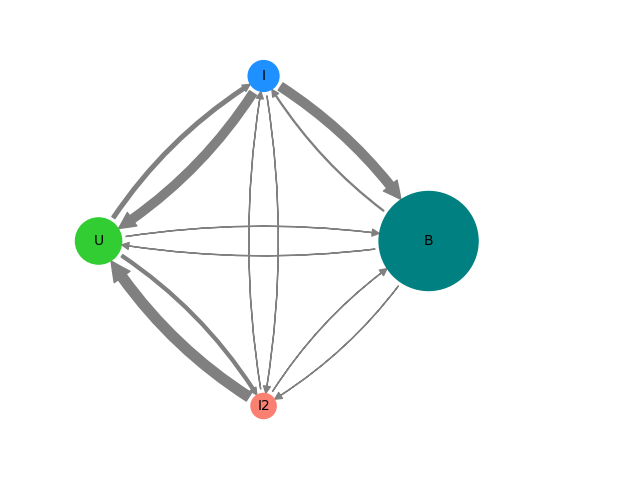

In [96]:
fig,ax=plt.subplots(1, figsize=(8,6))
mplt.plot_markov_model(mmodel, 
                       pos=np.array([[1,-1],[1,1],[2,0],[0,0]]), 
                       state_colors=colors[:pc], state_labels=state_labels,
                       arrow_labels=None, arrow_scale=1.4, ax=ax
                      )
plt.savefig(f'plots/markov_model_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [97]:
flux = msm.tpt(model, mdis[2], mdis[3])
cg, cgflux = flux.coarse_grain(mdis)
print(cgflux.committor)
paths, path_fluxes = cgflux.pathways(fraction=0.99)
for a,i in enumerate(paths):
    print(i, path_fluxes[a]/np.sum(path_fluxes))

[0.         0.98374798 0.46268728 1.        ]
[0 2 3] 0.9502318719875639
[0 1 3] 0.049768128012436


In [98]:
get_frames(model, mdis, dtrj, stds)

([1, 1, 4, 1],
 [array([  1334,  11453,  11454, ..., 322054, 322055, 322057]),
  array([  3690,   3694,   3697, ..., 317733, 317752, 317754]),
  array([ 63145,  63146,  63147, ..., 169596, 169600, 169601]),
  array([   926,    930,    931, ..., 317701, 317702, 317705])])

# h=2, i=0, cl=1500, ml=10, pc=4

In [18]:
h=2
i=0
cl=1500
ml=10
pc=4

In [19]:
tic2 = np.load(f'ticas/h{h}_tic2_{i}.npz')
tic2 = np.concatenate(([tic2[k] for k in list(tic2)]))

dtrj = np.load(f'urf/saved_h{2}_msm/dtraj_{i}_{cl}.npz')
dtrj = [dtrj[k] for k in list(dtrj)]

model = msm.estimate_markov_model(dtrj, lag=ml)
model.pcca(pc)
mdis=model.metastable_sets
mdis

[array([  98,  299,  455,  760,  908,  938,  987, 1133]),
 array([   0,    2,    3, ..., 1497, 1498, 1499]),
 array([  70,   89,  141,  171,  215,  316,  330,  410,  547,  641,  694,
         725,  820,  843,  856,  868,  875,  936,  984, 1019, 1118, 1175,
        1211, 1282, 1328, 1363, 1396, 1419, 1422]),
 array([   1,    6,   13,   16,   20,   24,   31,   32,   40,   41,   50,
          57,   63,   65,   72,   77,   81,   84,  100,  101,  109,  119,
         125,  130,  131,  134,  136,  140,  143,  146,  152,  154,  169,
         174,  178,  181,  190,  198,  201,  202,  213,  214,  216,  227,
         228,  242,  243,  246,  248,  249,  255,  267,  270,  274,  277,
         280,  289,  290,  293,  312,  321,  323,  325,  326,  337,  338,
         343,  347,  350,  358,  359,  360,  363,  364,  368,  372,  374,
         375,  377,  381,  385,  390,  406,  420,  423,  425,  446,  448,
         459,  465,  469,  473,  475,  478,  481,  483,  485,  496,  498,
         508,  510,  514,

In [20]:
pr = ana.analyze_msm_clusters(dtrj)
pr.take_data(np.load('../1_datasets/mopR_bindings/distance_alldata.npy', allow_pickle=True))
means, stds, probs = pr.get_mean()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:05<00:00, 25.68it/s]


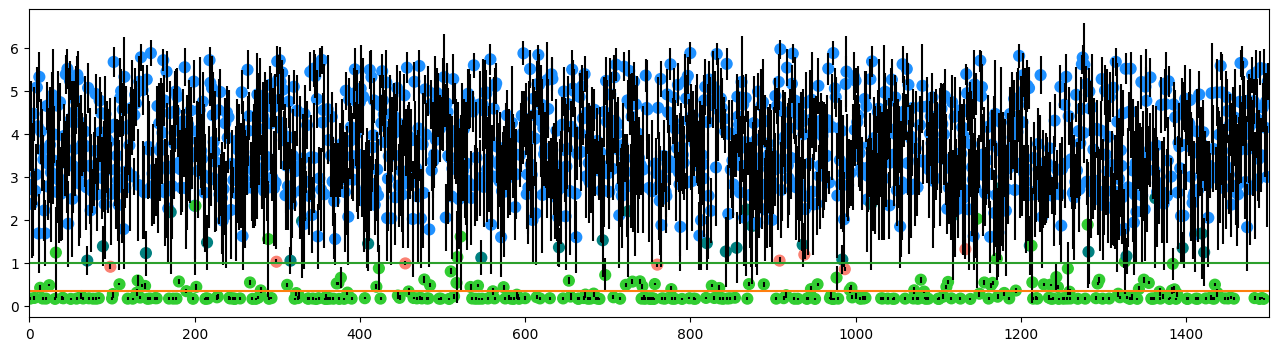

In [21]:
mcolors = np.zeros((cl))
for a,k in enumerate(model.metastable_sets):
    mcolors[k] = a
    
fig,ax=plt.subplots(1, figsize=(16,4))
ax.errorbar(range(cl), means, fmt='.', yerr=stds, ms=0, ecolor='black')
ax.scatter(range(cl), means, c=colors[mcolors.astype(int)], s=60)
ax.plot([0,cl-1],[0.35,0.35])
ax.plot([0,cl-1],[1,1])
ax.set_xlim(-1,cl)
plt.show()

In [22]:
state_labels=['I','U','I2','B']

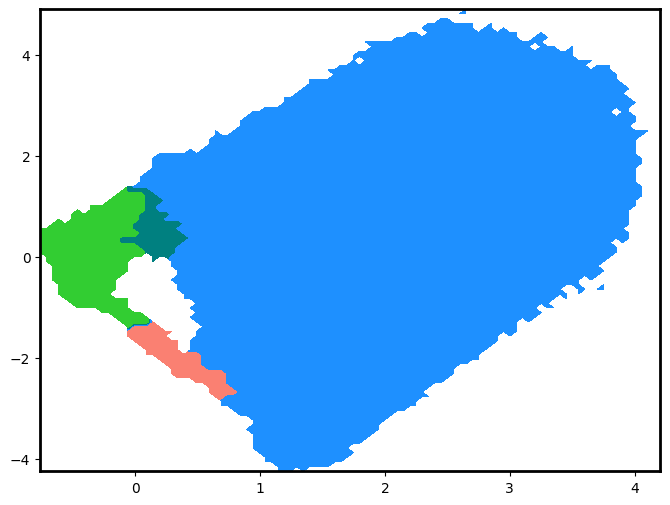

In [24]:
fig,ax=plt.subplots(1,figsize=(8,6))
mplt.plot_state_map(tic2[:,0], tic2[:,1],
                   model.metastable_assignments[np.concatenate((model.dtrajs_active))],
                   cbar=False, cmap=cmaps[pc-3], ax=ax)
ax.spines[:].set_linewidth(2)
plt.savefig(f'plots/statemap_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [114]:
for a, k in enumerate(mdis): print(a,model.pi[k].sum())

0 0.0005639458191577266
1 0.19905610426767784
2 0.00798047729208738
3 0.7923994726210781


In [115]:
fr = ml * 10 * 10**(-6)
for k in range(pc-1):
    for j in range(k+1,pc):
        print(k,j,model.mfpt(mdis[k], mdis[j])*fr, model.mfpt(mdis[j], mdis[k])*fr)

0 1 1.136565598340553 22.04450075064269
0 2 1.4633817945757988 23.646217297068645
0 3 0.39048864352383267 26.228595252845345
1 2 0.5014367161572565 0.48911574490105947
1 3 0.6724180615609038 3.9321386311027045
2 3 0.2752849836952815 3.367019266341256


In [116]:
mdtrj = ana.get_mdtrj(dtrj, mdis, output_type='trj')
mmodel = msm.estimate_markov_model(mdtrj, lag=ml)

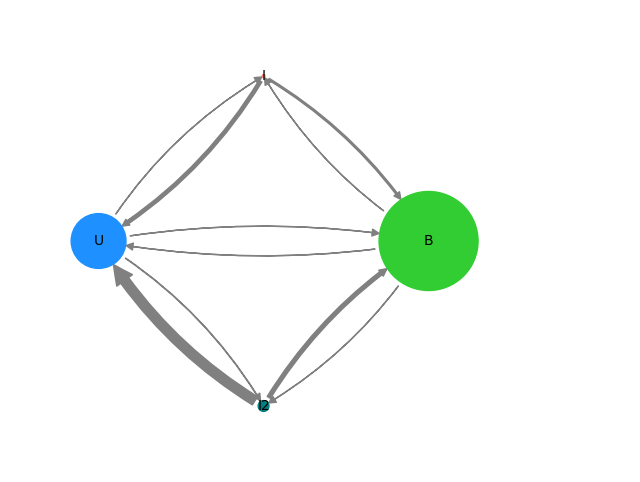

In [118]:
fig,ax=plt.subplots(1, figsize=(8,6))
mplt.plot_markov_model(mmodel, 
                       pos=np.array([[1,1],[0,0],[1,-1],[2,0]]), 
                       state_colors=colors[:pc], state_labels=state_labels,
                       arrow_labels=None, arrow_scale=1.4, ax=ax
                      )
plt.savefig(f'plots/markov_model_{h}_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [119]:
flux = msm.tpt(model, mdis[2], mdis[3])
cg, cgflux = flux.coarse_grain(mdis)
print(cgflux.committor)
paths, path_fluxes = cgflux.pathways(fraction=0.99)
for a,i in enumerate(paths):
    print(i, path_fluxes[a]/np.sum(path_fluxes))

[0.         0.55305714 0.0923783  1.        ]
[0 3] 0.8454507702751148
[0 2 3] 0.1545492297248851


In [120]:
get_frames(model, mdis, dtrj, stds)

([1, 1, 1, 1],
 [array([ 78423, 140119, 140293, 143431, 143472, 144801, 145409, 145429,
         145456, 259694, 259699, 259707, 260006, 260010, 260013, 260014,
         260021, 260030, 260031, 260033, 260036, 260038, 260040, 260041,
         260046, 260047, 260049, 260050, 260056, 260057, 260058, 260059,
         260061, 260062, 260066, 260069, 260072, 260074, 260078, 319558,
         319660, 319662, 319666, 319667, 319668, 319669, 319670, 319671,
         319672, 319673, 319675, 319967, 319968, 319969, 319970, 319971,
         319980, 319983, 319986, 319988, 319991, 319995, 319996, 319997,
         319999, 320000, 320001, 320014, 320016, 320025, 320035, 320036,
         320037, 320038, 320041, 320042, 320043, 320044, 320046, 320050,
         320051, 320052, 320053, 320056, 320060, 320062, 320063, 320066,
         320077, 320078, 320081, 320085, 320086, 320092, 320100, 320147,
         320149, 320174, 320663, 320664, 320797, 321062, 321069, 321071,
         321072, 321073, 321076, 321